In [1]:
import os
model_dir = "./models"
data_dir = "./data"

In [6]:
def load_data(dataset):
    data_path = {
        'train': './data/train_enc.tsv',
        'dev': './data/dev_enc.tsv',
        'test': './data/test_enc_unlabeled.tsv'
    }
    res = []
    if dataset in ['train','dev']:
        for x in open(data_path[dataset], encoding='utf-8'):
            x = x.rstrip('\n\r').split('\t')
            x[0] = int(x[0])
            res.append(x)
    elif dataset == 'test':
        for x in open(data_path[dataset], encoding='utf-8'):
            x = x.rstrip('\n\r')
            res.append(x)
    return res

In [7]:
train = load_data('train')
dev = load_data('dev')
test_texts = load_data('test')
train_labels = [x[0] for x in train]
train_texts = [x[1] for x in train]
dev_labels = [x[0] for x in dev]
dev_texts = [x[1] for x in dev]
print("Train size:", len(train_labels))
print("Dev size:", len(dev_labels))

Train size: 16220
Dev size: 2027


In [8]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pickle
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from tensorflow.keras.layers import BatchNormalization, LayerNormalization

/var/folders/34/7y6hjt956tj2llwtmwrh9rb80000gn/T/ipykernel_13352/2338092678.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-18 20:25:04.536582: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from gensim.models.phrases import Phrases, Phraser
from gensim.models import FastText

In [43]:
embedding_dim = 300
sent = [text.split() for text in train_texts]
phrases = Phrases(sent)
sentences = phrases[sent]
fasttext_model = FastText(vector_size=embedding_dim)
fasttext_model.build_vocab(sentences)
len(fasttext_model.wv.key_to_index)

6813

In [44]:
fasttext_model.train(sentences, total_examples=len(sentences), epochs=100)

(19576915, 31241000)

In [45]:
joblib.dump(fasttext_model, './models/fasttext3.joblib')

['./models/fasttext3.joblib']

In [10]:
fasttext_model = joblib.load('./models/fasttext3.joblib')

In [12]:
max_len = 0
for text in test_texts+dev_texts+train_texts:
    max_len = max(len(text.split()),max_len)
print(max_len)

59


In [13]:
# Defining pre-processing parameters
trunc_type = 'post'
padding_type = 'post'

tokenizer = Tokenizer(num_words=None, char_level=False)
# most frequent (num_words - 1) words will be kept
tokenizer.fit_on_texts(train_texts + dev_texts + test_texts)

In [14]:
# Get the word_index
word_index = tokenizer.word_index  # start from 1 {word: index}
vocab_size = len(word_index) + 1
print(vocab_size)

18180


In [16]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = fasttext_model.wv[word]
    embedding_matrix[i, :] = embedding_vector

In [17]:
training_sequences = tokenizer.texts_to_sequences(train_texts)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(dev_texts)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded = pad_sequences(test_sequences,
                            maxlen = max_len,
                            padding = padding_type,
                            truncating = trunc_type)

print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)
print('Shape of test tensor: ', test_padded.shape)

Shape of training tensor:  (16220, 59)
Shape of testing tensor:  (2027, 59)
Shape of test tensor:  (2028, 59)


In [18]:
train_label_matrix = tf.keras.utils.to_categorical(train_labels, num_classes=2)
dev_label_matrix = tf.keras.utils.to_categorical(dev_labels, num_classes=2)

In [47]:
# Define LSTM Model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(300, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(300)))
model.add(Dropout(0.5))
model.add(Dense(2, kernel_initializer=tf.keras.initializers.he_normal(seed=0), activation='softmax'))
# Compile LSTM Model
learning_rate = 0.002
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
# optmizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_dir, "lstm.keras"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    monitor="val_loss",
    restore_best_weights=True
)
    

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
history = model.fit(training_padded, train_label_matrix,
                    validation_data=(testing_padded, dev_label_matrix),
                    batch_size=32, epochs=50, verbose=1,
                    callbacks=[checkpointer, earlystop])
model = tf.keras.models.load_model(os.path.join(model_dir, "lstm.keras"))

train_score = model.evaluate(training_padded, train_label_matrix, batch_size=32)
dev_score = model.evaluate(testing_padded, dev_label_matrix, batch_size=32)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 1/50
507/507 [==============================] - 782s 2s/step - loss: 0.5627 - accuracy: 0.7081 - val_loss: 0.4412 - val_accuracy: 0.7958
Epoch 2/50
507/507 [==============================] - 868s 2s/step - loss: 0.4458 - accuracy: 0.7961 - val_loss: 0.3976 - val_accuracy: 0.8283
Epoch 3/50
507/507 [==============================] - 781s 2s/step - loss: 0.3472 - accuracy: 0.8509 - val_loss: 0.3625 - val_accuracy: 0.8505
Epoch 4/50
507/507 [==============================] - 702s 1s/step - loss: 0.2540 - accuracy: 0.8992 - val_loss: 0.3462 - val_accuracy: 0.8717
Epoch 5/50
507/507 [==============================] - 891s 2s/step - loss: 0.1978 - accuracy: 0.9252 - val_loss: 0.4285 - val_accuracy: 0.8599
Epoch 6/50
507/507 [==============================] - 969s 2s/step - loss: 0.1680 - accuracy: 0.9380 - val_loss: 0.3841 - val_accuracy: 0.8762
Epoch 7/50
507/507 [==============================] - 872s 2s/step - loss: 0.1556 - accuracy: 0.9442 - val_loss: 0.4126 - val_accuracy: 0.8742

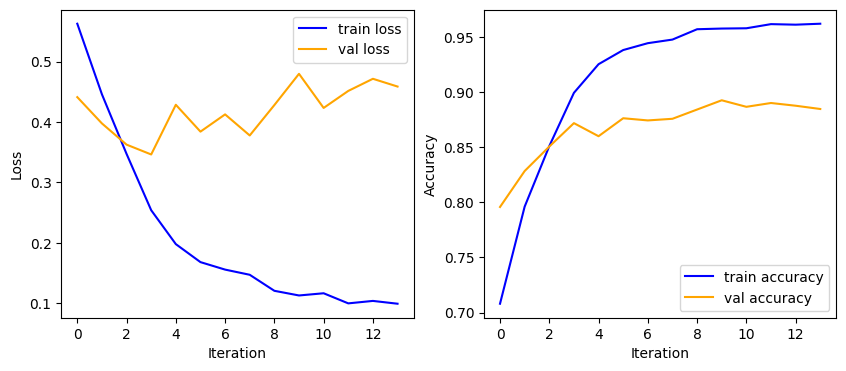

In [48]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train loss", color="blue")
plt.plot(history.history["val_loss"], label="val loss", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train accuracy", color="blue")
plt.plot(history.history["val_accuracy"], label="val accuracy", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [53]:
# Define LSTM Model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(300, return_sequences=True)))
model.add(Dropout(0.5))
model.add(LayerNormalization())
model.add(Bidirectional(LSTM(300)))
model.add(Dropout(0.5))
model.add(LayerNormalization())
model.add(Dense(2, kernel_initializer=tf.keras.initializers.he_normal(seed=0), activation='softmax'))
# Compile LSTM Model
learning_rate = 0.002
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
# optmizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_dir, "lstm.keras"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    monitor="val_loss",
    restore_best_weights=True
)
    

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
history = model.fit(training_padded, train_label_matrix,
                    validation_data=(testing_padded, dev_label_matrix),
                    batch_size=32, epochs=50, verbose=1,
                    callbacks=[checkpointer, earlystop])
model = tf.keras.models.load_model(os.path.join(model_dir, "lstm.keras"))

train_score = model.evaluate(training_padded, train_label_matrix, batch_size=32)
dev_score = model.evaluate(testing_padded, dev_label_matrix, batch_size=32)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 1/50
507/507 [==============================] - 1473s 3s/step - loss: 0.6660 - accuracy: 0.6571 - val_loss: 0.5705 - val_accuracy: 0.7701
Epoch 2/50
507/507 [==============================] - 1548s 3s/step - loss: 0.5033 - accuracy: 0.7621 - val_loss: 0.5068 - val_accuracy: 0.8007
Epoch 3/50
507/507 [==============================] - 1166s 2s/step - loss: 0.4204 - accuracy: 0.8174 - val_loss: 0.4359 - val_accuracy: 0.8278
Epoch 4/50
507/507 [==============================] - 1244s 2s/step - loss: 0.3359 - accuracy: 0.8613 - val_loss: 0.4628 - val_accuracy: 0.8377
Epoch 5/50
507/507 [==============================] - 1267s 2s/step - loss: 0.2695 - accuracy: 0.8978 - val_loss: 0.4969 - val_accuracy: 0.8604
Epoch 6/50
507/507 [==============================] - 1101s 2s/step - loss: 0.2362 - accuracy: 0.9139 - val_loss: 0.4882 - val_accuracy: 0.8693
Epoch 7/50
507/507 [==============================] - 1107s 2s/step - loss: 0.1877 - accuracy: 0.9338 - val_loss: 0.5810 - val_accuracy:

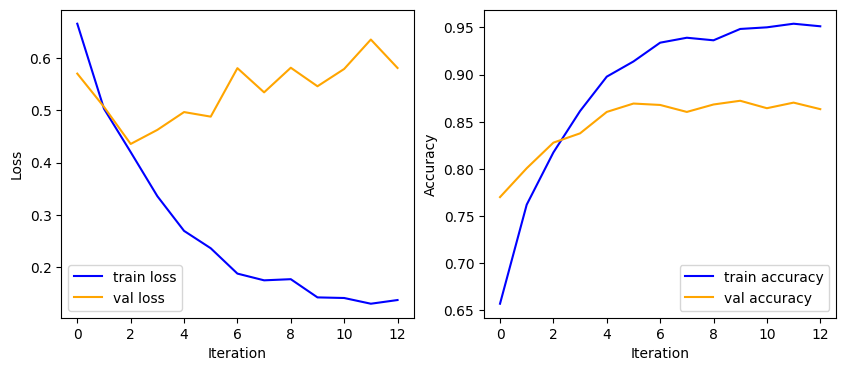

In [54]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train loss", color="blue")
plt.plot(history.history["val_loss"], label="val loss", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train accuracy", color="blue")
plt.plot(history.history["val_accuracy"], label="val accuracy", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [19]:
# Define LSTM Model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(300, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(300)))
model.add(Dropout(0.5))
model.add(Dense(2, kernel_initializer=tf.keras.initializers.he_normal(seed=0), activation='softmax'))
# Compile LSTM Model
learning_rate = 0.002
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
# optmizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_dir, "lstm.keras"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    monitor="val_loss",
    restore_best_weights=True)
    

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
history = model.fit(training_padded, train_label_matrix,
                    validation_data=(testing_padded, dev_label_matrix),
                    batch_size=32, epochs=50, verbose=1,
                    callbacks=[checkpointer, earlystop])
model = tf.keras.models.load_model(os.path.join(model_dir, "lstm.keras"))

train_score = model.evaluate(training_padded, train_label_matrix, batch_size=32)
dev_score = model.evaluate(testing_padded, dev_label_matrix, batch_size=32)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 1/50
507/507 [==============================] - 1175s 2s/step - loss: 0.5642 - accuracy: 0.7117 - val_loss: 0.4575 - val_accuracy: 0.7849
Epoch 2/50
507/507 [==============================] - 1038s 2s/step - loss: 0.4402 - accuracy: 0.8003 - val_loss: 0.3844 - val_accuracy: 0.8288
Epoch 3/50
507/507 [==============================] - 1108s 2s/step - loss: 0.3329 - accuracy: 0.8596 - val_loss: 0.3402 - val_accuracy: 0.8619
Epoch 4/50
507/507 [==============================] - 1077s 2s/step - loss: 0.2535 - accuracy: 0.9006 - val_loss: 0.3405 - val_accuracy: 0.8619
Epoch 5/50
507/507 [==============================] - 1375s 3s/step - loss: 0.2010 - accuracy: 0.9254 - val_loss: 0.3592 - val_accuracy: 0.8742
Epoch 6/50
507/507 [==============================] - 1696s 3s/step - loss: 0.1655 - accuracy: 0.9374 - val_loss: 0.3484 - val_accuracy: 0.8851
Epoch 7/50
507/507 [==============================] - 1504s 3s/step - loss: 0.1431 - accuracy: 0.9454 - val_loss: 0.3494 - val_accuracy:

In [20]:
y_pred = model.predict(test_padded)

64/64 [==============================] - 41s 573ms/step


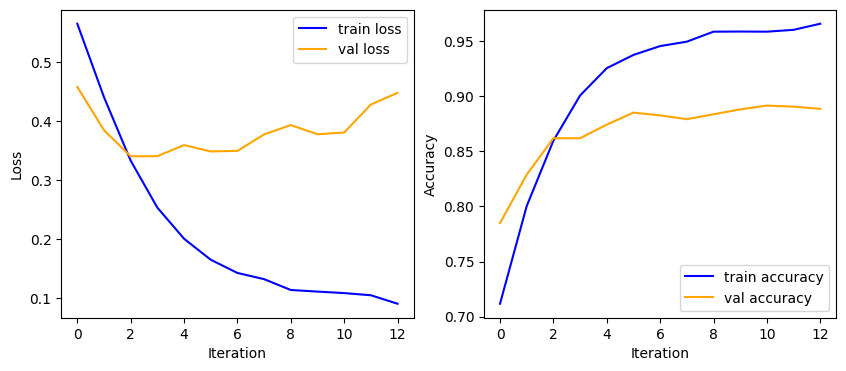

In [24]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train loss", color="blue")
plt.plot(history.history["val_loss"], label="val loss", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train accuracy", color="blue")
plt.plot(history.history["val_accuracy"], label="val accuracy", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()